# Regionalização de Bacias usando Redes Neurais

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %%bash
# cp -r /content/drive/"My Drive"/DEHA/RegBaciasCE /content
# mkdir -p RegBaciasCE/src/models/NewFFNN3/CrossValid
# nvidia-smi

## Importing Packages

In [2]:
import sys
sys.path.append("..")
sys.path.append("../src")
sys.path.append("../scripts")
sys.path.append("../database")

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from funcoes_auxiliares import *
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt


In [4]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

In [5]:
pd.options.display.max_columns = 999

import warnings

warnings.filterwarnings('ignore')


In [6]:
bacias_com_problema = [36220000]

In [7]:
dados = pd.read_csv("../database/Formated inputs/NewFFNNData.csv").query(f"`Estações ANA` not in {bacias_com_problema}")\
                                .reset_index(drop=True)
bacias = list(set(dados['Estações ANA']))
bacias.sort()
print(len(dados))
dados.head()

9700


,Estações ANA,Declividade - D (%),Comprimento do rio principal - CT (km),Área de contribuição da estação fluviométrica - A (km2),Perímetro da área de contribuição da estação fluviométrica - P (km),Comprimento total de drenagem - CTD (km),Densidade de drenagem - DD (km-1),Curve number médio – CN (mm),Parcela da bacia no cristalino - Cr,E_0,P_2,P_1,P_0,Q_0
0,34730000,0.069435,64319.016213,897.371509,211.282396,528.790311,0.589266,56.773914,0.0,130.000000,133.230,66.066,204.2900,7.884968
1,34730000,0.069435,64319.016213,897.371509,211.282396,528.790311,0.589266,56.773914,0.0,118.000000,66.066,204.290,135.7800,6.138600
2,34730000,0.069435,64319.016213,897.371509,211.282396,528.790311,0.589266,56.773914,0.0,121.889904,204.290,135.780,142.9200,3.870129
3,34730000,0.069435,64319.016213,897.371509,211.282396,528.790311,0.589266,56.773914,0.0,129.330288,135.780,142.920,12.5080,2.136953
4,34730000,0.069435,64319.016213,897.371509,211.282396,528.790311,0.589266,56.773914,0.0,151.559616,142.920,12.508,3.0347,1.040503


In [8]:
columns = [
#        'Comprimento do rio principal - CT (km)',
       'Área de contribuição da estação fluviométrica - A (km2)',
       'Comprimento total de drenagem - CTD (km)',
       'Curve number médio – CN (mm)', 'Parcela da bacia no cristalino - Cr',
#         'P_5', 'P_4', 'P_3',
       'P_2', 'P_1', 'P_0','E_0',
#         'Q_2','Q_1'
]

In [9]:
#X = dados.drop(drop_columns,axis=1)
X = dados[columns]
Y = dados['Q_0'].values

#scaler = StandardScaler()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=columns)

In [10]:
print(len(X))
X.head()

9700


,Área de contribuição da estação fluviométrica - A (km2),Comprimento total de drenagem - CTD (km),Curve number médio – CN (mm),Parcela da bacia no cristalino - Cr,P_2,P_1,P_0,E_0
0,0.019908,0.011969,0.0,0.0,0.203116,0.107835,0.333448,0.437452
1,0.019908,0.011969,0.0,0.0,0.100721,0.333448,0.221624,0.348627
2,0.019908,0.011969,0.0,0.0,0.311451,0.221624,0.233278,0.377420
3,0.019908,0.011969,0.0,0.0,0.207004,0.233278,0.020416,0.432495
4,0.019908,0.011969,0.0,0.0,0.217889,0.020416,0.004953,0.597038


In [11]:
P =X[[#'P_5', 'P_4', 'P_3',
          'P_2', 'P_1', 'P_0']].values
EF =X.drop([#'P_5', 'P_4', 'P_3',
            'P_0', 'P_1', 'P_2'],axis=1).values
P[0]

array([0.20311619, 0.10783469, 0.33344759])

In [12]:
# Parâmetros
seq = P.shape[1]
# P = np.array(P)
# P = np.reshape(P,[-1,1,seq])
P = np.reshape(P,[-1,seq,1])
P[0]

array([[0.20311619],
       [0.10783469],
       [0.33344759]])

### Definição do modelo

In [13]:
INIT_LR = 0.001
EPOCHS = 200
BS = 64  # Diminua o tamanho dos lotes se você não tiver memória suficiente


physicalInput = EF.shape[1]
n_classes = 1

n_physic = 15
# n_h2 = n_physic
n_LSTM=15
n_dense = n_LSTM + n_physic + 10


In [14]:


Cdata = Input(shape = (physicalInput,),dtype='float32', name='physical_data')
xc = Cdata
xc = Dense(n_physic,activation ='relu',name='hidden_layer_physical')(xc)
xc = Dense(n_physic,activation ='relu',name='hidden_layer_physical_2')(xc)

Pdata = Input(shape = (P.shape[1],P.shape[2]),dtype='float32', name='pluviometric_data')
xp = Pdata
xp = LSTM(n_LSTM, activation='relu',return_sequences=True,
          name='lstm_layer_pluviometric')(xp)
xp = LSTM(n_LSTM, activation='relu',
          name='lstm_layer_pluviometric_2')(xp)
          
#xp = Dense(n_LSTM,activation ='relu',name='dense_layer_pluviometric')(xp)
x = Concatenate(name="hidden_layer_concatenated")([xc,xp])
x = Dense(n_dense,activation ='relu',name="hidden_layer")(x)
#x = Dropout(0.1)(x)

y = Dense(1,activation ='linear',name="streamflow")(x)


model = Model(inputs=[Cdata, Pdata], outputs=[y])
model.summary()

2022-02-22 08:14:30.410504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 physical_data (InputLayer)     [(None, 5)]          0           []                               
                                                                                                  
 pluviometric_data (InputLayer)  [(None, 3, 1)]      0           []                               
                                                                                                  
 hidden_layer_physical (Dense)  (None, 15)           90          ['physical_data[0][0]']          
                                                                                                  
 lstm_layer_pluviometric (LSTM)  (None, 3, 15)       1020        ['pluviometric_data[0][0]']      
                                                                                              

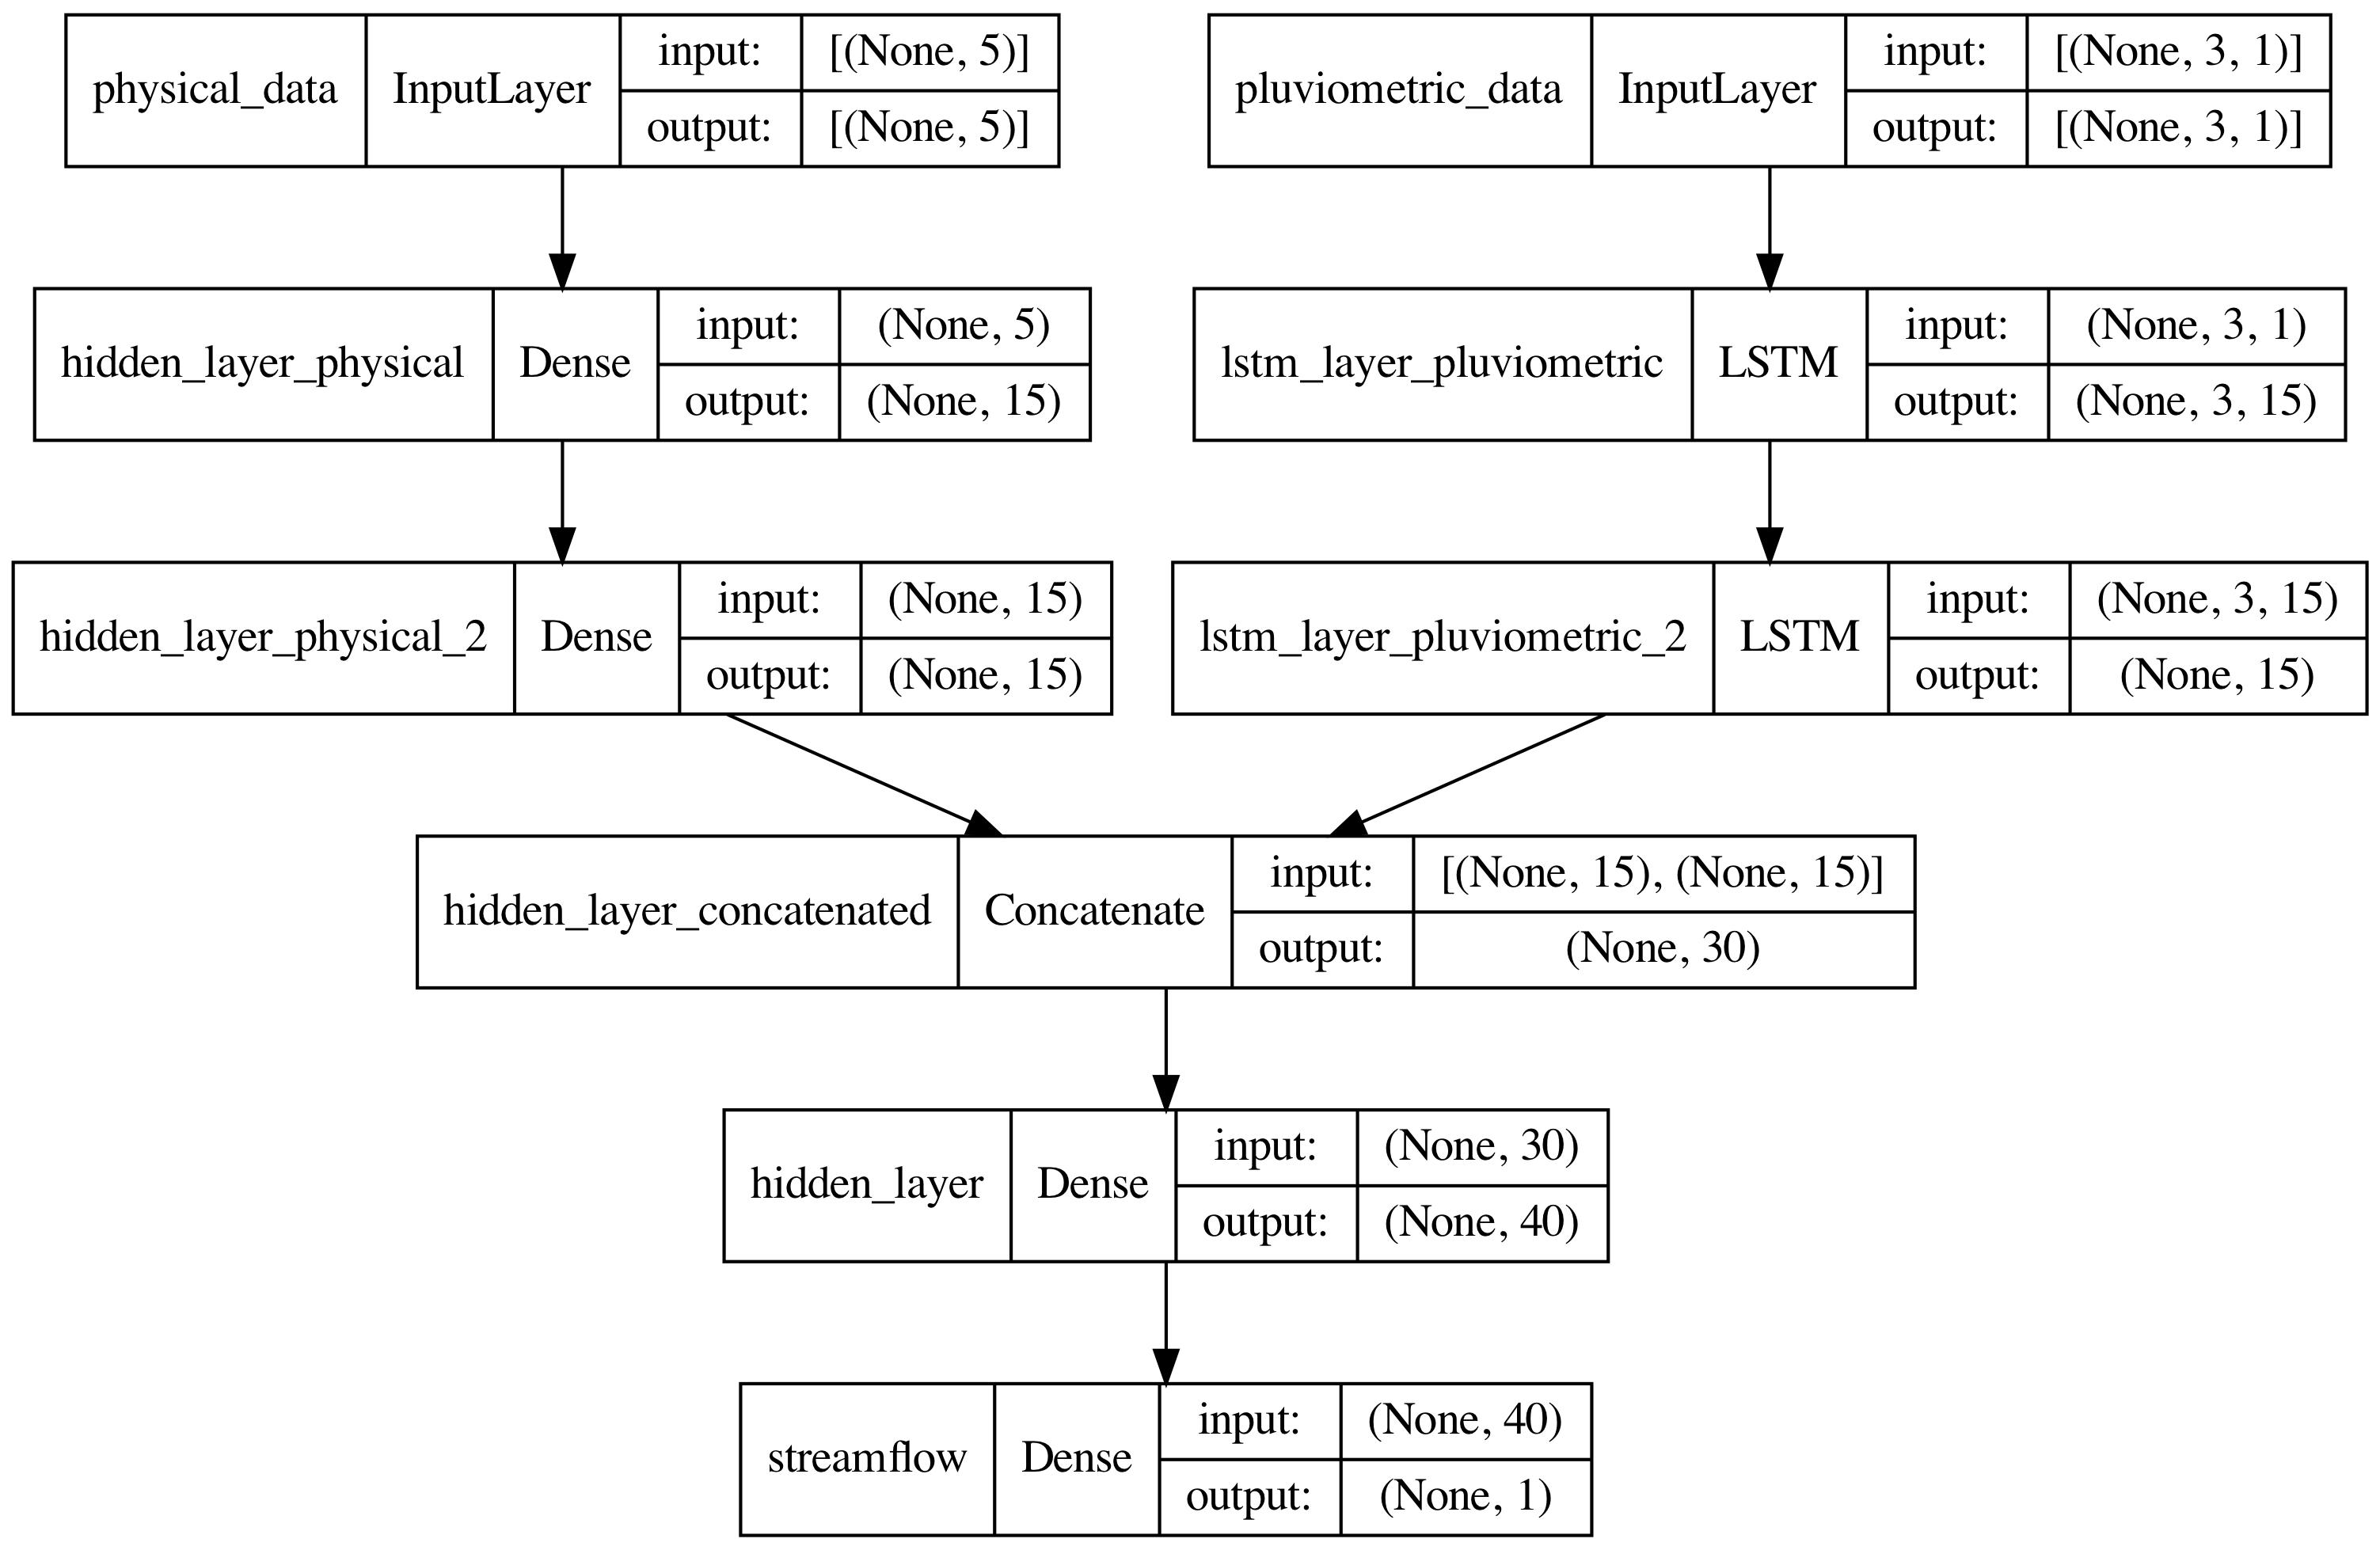

In [15]:
tf.keras.utils.plot_model(
    model, to_file='lstm_rg_model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=300
)

In [16]:
relu = lambda x: max(x,0)

In [17]:
# model_dir = '../src/models/legacy/Donut'
base_dir = '../src/models/NewLSTM/'
model_dir = os.path.join(base_dir,'CrossValid_SEED_8369_NSE_0696')
model_code = 'NewLSTM'



In [18]:
nome, n_obs,nse, cor, rmse = [], [], [], [], []

for bacia in bacias:

    idx = dados['Estações ANA'] == bacia

    EFtreino, Ptreino, Ytreino = EF[~idx], P[~idx], Y[~idx]
    EFteste, Pteste, Yteste = EF[idx], P[idx], Y[idx]



    model.load_weights(os.path.join(model_dir,'weights.%s_%d.hdf5'%(model_code,bacia)))
    #     model.compile(loss=[loss],optimizer = opt,
    #                 metrics=[metrics])


    Y_ = model.predict([EFteste, Pteste])

    Y_Prev = np.vectorize(relu)(Y_)


    Y_test = np.expand_dims(Yteste,1)

    k_ = np.mean(Y_test) / np.mean(Y_Prev)

    nome.append(bacia)
    cor.append(np.corrcoef(Y_Prev,Y_test)[1][0])
    rmse.append(RMSE(Y_test,Y_Prev))
    nse.append(NASH(Y_test,Y_Prev))
    n_obs.append(len(Y_test))


    pd.DataFrame({"Bacia":nome, "Observacoes":n_obs, "NSE":nse,"Cor": cor,"RMSE": rmse})

### Performance dos modelos

In [19]:
results = pd.DataFrame({"Bacia":nome, "Observacoes":n_obs, "NSE":nse,"Cor": cor,"RMSE": rmse})


In [20]:
results["NSE"].apply(relu).mean()#[results.Bacia != 36220000]


0.6025109734144035

In [21]:
results[results["Bacia"] != 35668000]["NSE"].apply(relu).mean()
results.query(f"""Bacia not in {bacias_com_problema+[35668000]}""")["NSE"].apply(relu).mean()

0.6287071026932906

In [22]:
bacias_barros_2013 = (34750000, 35050000, 35125000, 35170000, 35210000,
                      35260000, 35263000, 35880000, 35950000, 36020000,
                      36125000, 36130000, 36160000, 36210000, 36250000,
                      36270000, 36290000, 36520000)
results_barros_2013 = results.query(f"""Bacia in {bacias_barros_2013}
""")["NSE"].apply(relu).mean()


results_barros_2013

0.6958242881906583

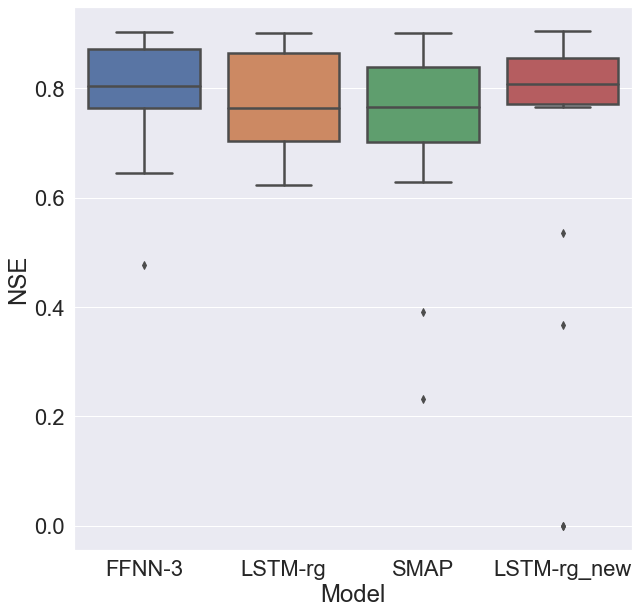

In [23]:
### Comparação com modelos já treinado

ResultsFFN3 = pd.read_csv("../database/output/Results/ResultadosFFNN3.csv")\
                        .sort_values("Bacia")\
                        .reset_index(drop=True)

models_results = pd.read_excel("../database/Table_2.xlsx",sheet_name="Planilha1",skiprows=2)
models_results_columns = ["Basin","n_obs","FFNN-1","FFNN-2","FFNN-3","LSTM-rg","SMAP","LSTM-ic","FFNN-ic"]
models_results.columns = models_results_columns
# models_results = models_results.set_index("Basin")

rslt = pd.merge(results[['Bacia','NSE']],ResultsFFN3[['Bacia','NSE']],on='Bacia',suffixes=('_LSTM','_FFNN3'))
rslt = rslt.rename(columns={
    "NSE_LSTM":"LSTMrg",
    "NSE_FFNN3":"FFNN3"
})

import matplotlib.pyplot as plt
import seaborn as sns

results_ =models_results.merge(rslt,left_on="Basin",right_on="Bacia",how="outer")\
                .drop(columns=["Bacia"])\
                .rename(columns={"FFNN3":"FFNN-3_used","LSTMrg":"LSTM-rg_new","Basin":"Bacia"})\
                

boxplot_df = pd.melt(results_[["Bacia","FFNN-3_used","LSTM-rg","SMAP","LSTM-rg_new"]]\
                     .query(f"""Bacia in {bacias_barros_2013}""")\
                     .rename(columns={"FFNN-2_used":"FFNN-2","FFNN-3_used":"FFNN-3"})\
                     .iloc[:,1:])
boxplot_df["value"] = boxplot_df["value"].apply(relu)
boxplot_df = boxplot_df.rename(columns={
    "variable":"Model",
    "value":"NSE"
})

#boxplot_df["NSE"] = boxplot_df["NSE"].apply(relu)
boxplot_df.head()

plt.figure(figsize=(10,10))

sns.set_theme(style="whitegrid")

sns.set_color_codes("dark")

sns.set_style("darkgrid", 
#               {"axes.facecolor": ".9"}
             )

sns.set(font_scale=2)

ax = sns.boxplot(x='Model',y='NSE',data=boxplot_df,linewidth=2.5)



In [24]:
# results.to_csv("../Database/output/ResultadosNewLSTM-rg.csv",index=False)